In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import scipy.signal as signal
import pandas as pd
#import pywt


/Users/diegotaquiri/miniconda3/envs/isb/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# biosignalsnotebooks python package
import biosignalsnotebooks as bsnb

# Scientific packages
from numpy import linspace, max, min, average, std, sum, sqrt, where, argmax
from scipy.integrate import cumtrapz
from scipy.signal import welch

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
from scipy.signal import butter, filtfilt, firwin, iirnotch
import pywt
from scipy.stats import kurtosis, entropy
from sklearn.metrics import mean_squared_error


### EMG isometrico

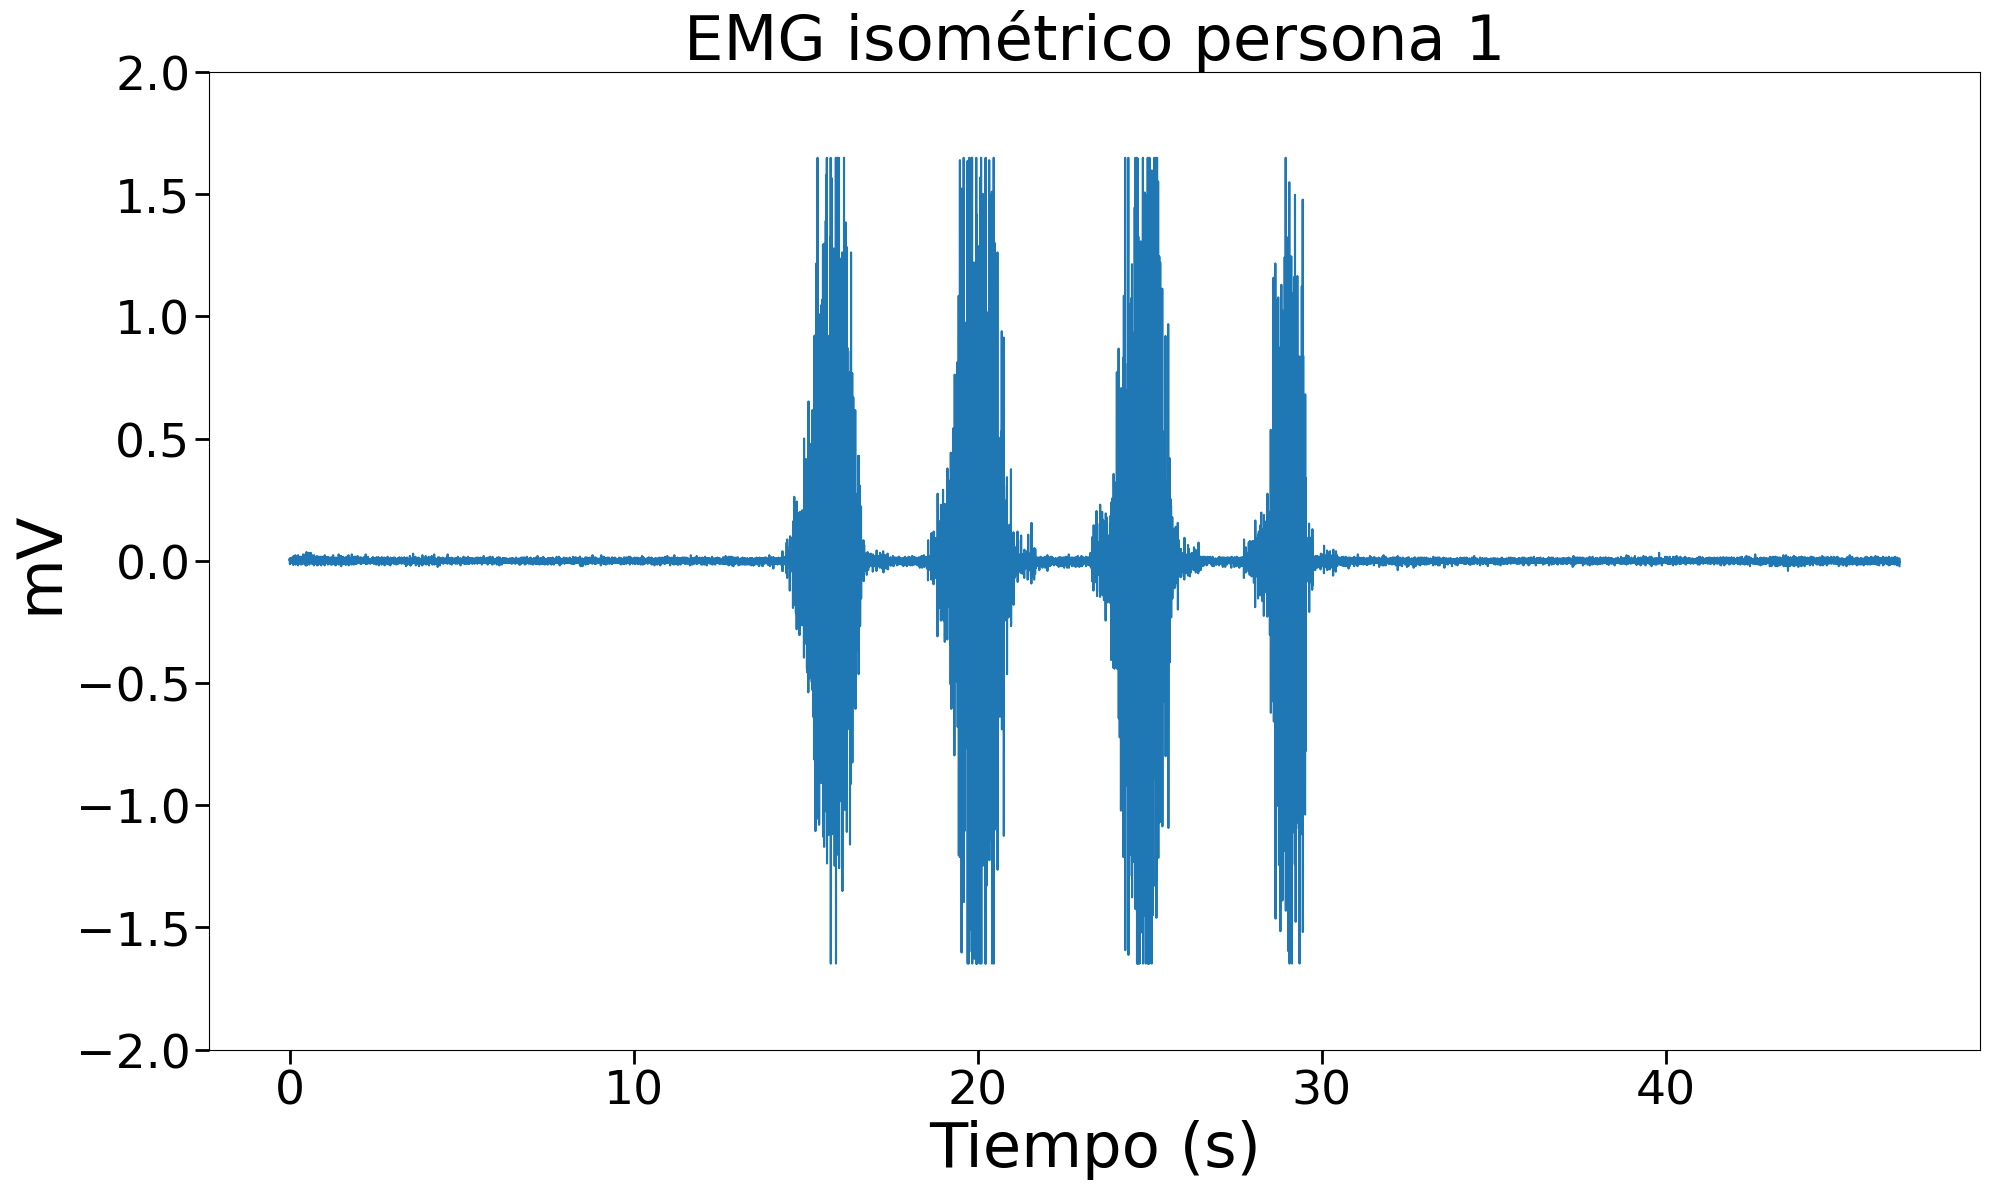

In [29]:
data=np.loadtxt("./../Laboratorio 04/emg_raw_data/isb-isometrico-armando/opensignals_98D3B1FD3DA9_2024-04-12_12-16-36.txt",skiprows=3)

# Convert bits to mV and center the signal
bits = 10  # Bits de la salida
volt_range = 3.3  # Rango de voltaje en milivoltios
data_mV = (data[:, 5] * volt_range / (2**bits - 1))  # Convertir los bits a mV
data_mV_centered = data_mV - np.mean(data_mV)  # Centrar la señal

# Rectify the signal (full-wave rectification)
data_mV_rectified = np.abs(data_mV_centered)

time = np.arange(len(data_mV))/1000 

plt.figure(figsize=(20,12))

plt.plot(time,data_mV_centered)

plt.ylim(-2, 2)
#plt.xlim(0, 31)
plt.tick_params(axis='both', which='major', labelsize=34, width=2, length=10)
plt.xlabel('Tiempo (s)', fontsize=45)
plt.ylabel('mV', fontsize=45)
plt.title('EMG isométrico persona 1', fontsize=45)
plt.tight_layout()


plt.savefig("plots/isb-isometrico-armando.png")


/Users/diegotaquiri/miniconda3/envs/isb/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1961: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '


       Average  Standard Deviation   Maximum   Minimum       RMS      Area  \
0     0.005130            0.004425  0.025319  0.000076  0.006775  1.021544   
1     0.005067            0.004364  0.025319  0.000077  0.006687  1.009557   
2     0.005374            0.004584  0.025319  0.000023  0.007063  1.067811   
3     0.004692            0.004222  0.025319  0.000023  0.006312  0.937130   
4     0.004999            0.004380  0.025319  0.000003  0.006646  0.996165   
...        ...                 ...       ...       ...       ...       ...   
1161  0.003934            0.003596  0.020078  0.000025  0.005330  0.779278   
1162  0.004045            0.003724  0.020078  0.000109  0.005498  0.804694   
1163  0.003537            0.002880  0.016684  0.000048  0.004561  0.703290   
1164  0.004037            0.003265  0.016684  0.000048  0.005192  0.803116   
1165  0.004064            0.003475  0.021892  0.000048  0.005347  0.800991   

      Total Power  Median Frequency  Max Frequency  Kurtosis   

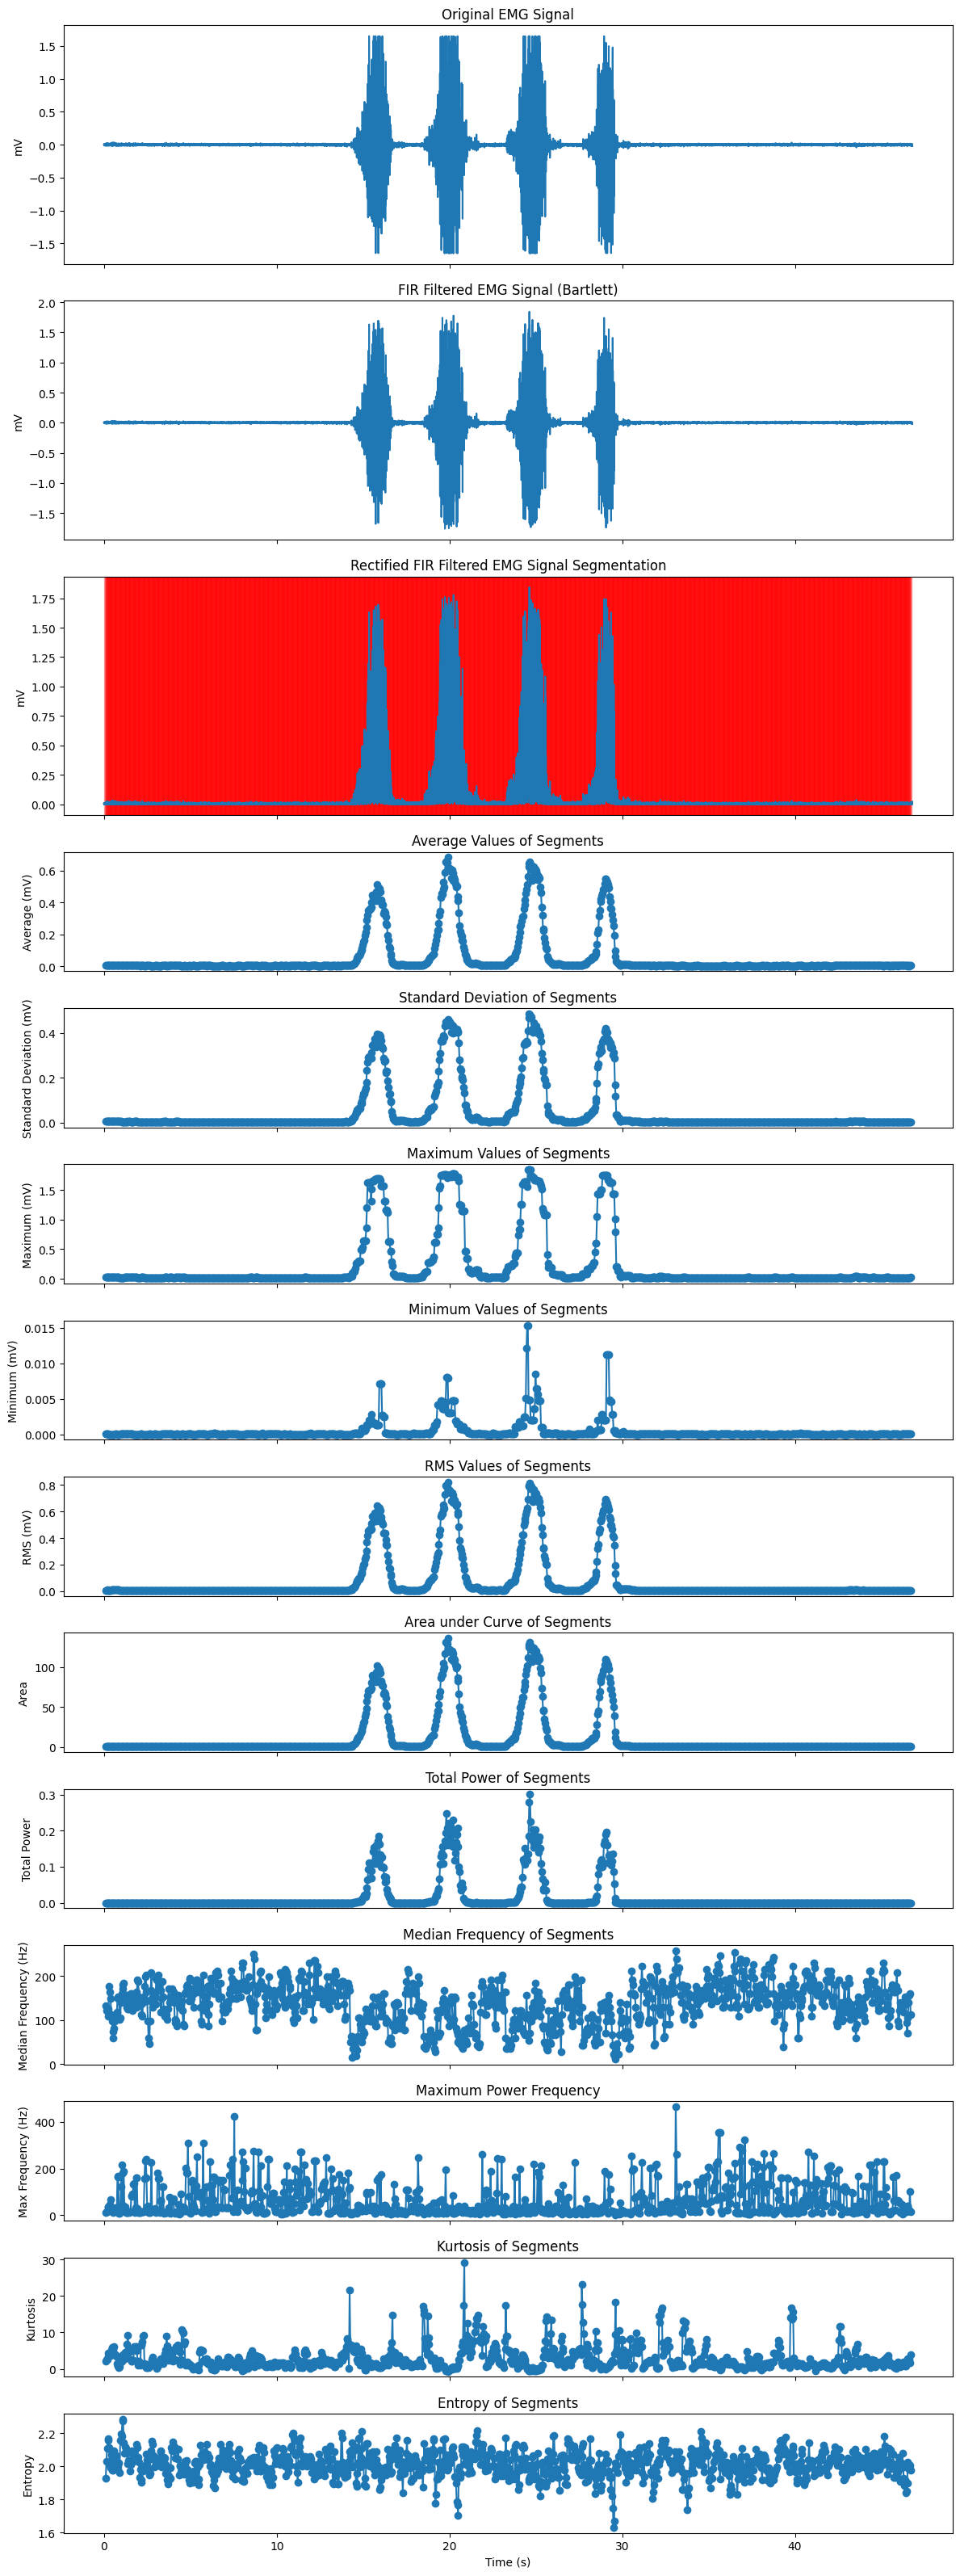

In [30]:
# FIR filter design
def bartlett_fir(data, cutoff, fs, order=20):
    coeff = firwin(order + 1, cutoff / (fs / 2), window='bartlett')
    filtered_data = filtfilt(coeff, 1.0, data)
    return filtered_data

# Apply FIR filter
filtered_fir_bartlett = bartlett_fir(data_mV_centered, cutoff=400, fs=1000, order=20)
filtered_fir_bartlett_rectified = np.abs(filtered_fir_bartlett)

# Segment the EMG signal
def segment_signal(signal, segment_length, increment, sampling_rate):
    segment_samples = int(segment_length * sampling_rate / 1000)
    increment_samples = int(increment * sampling_rate / 1000)
    segments = []
    for start in range(0, len(signal) - segment_samples + 1, increment_samples):
        end = start + segment_samples
        segments.append(signal[start:end])
    return np.array(segments), segment_samples, increment_samples, np.arange(0, len(signal) - segment_samples + 1, increment_samples)

# Segment parameters
segment_length = 200
increment = 40
sampling_rate = 1000

# Segment the rectified filtered signal
segments, segment_samples, increment_samples, segment_starts = segment_signal(filtered_fir_bartlett_rectified, segment_length, increment, sampling_rate)

# Additional feature extraction functions
def calculate_kurtosis(signal):
    return kurtosis(signal)

def calculate_entropy(signal):
    return entropy(np.histogram(signal, bins='fd')[0])

def calculate_snr(original_segment, filtered_segment):
    noise = original_segment - filtered_segment
    signal_power = np.mean(original_segment ** 2)
    noise_power = np.mean(noise ** 2)
    return 10 * np.log10(signal_power / noise_power) if noise_power != 0 else float('inf')

# Feature extraction function
def extract_features(segment, sampling_rate, original_signal, segment_start, segment_length):
    max_sample_value = np.max(segment)
    min_sample_value = np.min(segment)
    avg_sample_value = np.mean(segment)
    std_sample_value = np.std(segment)
    rms = np.sqrt(np.mean(segment ** 2))
    area = np.trapz(segment)
    f, P = welch(segment, fs=sampling_rate, window='hanning', noverlap=0, nfft=int(256.))
    area_freq = cumtrapz(P, f, initial=0)
    total_power = area_freq[-1]
    median_freq = f[np.where(area_freq >= total_power / 2)[0][0]]
    f_max = f[np.argmax(P)]
    kurt = calculate_kurtosis(segment)
    ent = calculate_entropy(segment)
    original_segment = original_signal[segment_start:segment_start + segment_length]
    snr = calculate_snr(original_segment, segment)
    return [avg_sample_value, std_sample_value, max_sample_value, min_sample_value, rms, area, total_power, median_freq, f_max, kurt, ent, snr]

# Extract features from each segment
features = []
for i, segment in enumerate(segments):
    segment_start = segment_starts[i]
    features.append(extract_features(segment, sampling_rate, data_mV_centered, segment_start, segment_samples))

features_df = pd.DataFrame(features, columns=['Average', 'Standard Deviation', 'Maximum', 'Minimum', 'RMS', 'Area', 'Total Power', 'Median Frequency', 'Max Frequency', 'Kurtosis', 'Entropy', 'SNR'])
print(features_df)

# Plot the original, filtered, and segmented signals with features
fig, axs = plt.subplots(14, 1, figsize=(12, 32), sharex=True, gridspec_kw={'height_ratios': [2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]})

# Plot original EMG signal
axs[0].plot(time, data_mV_centered)
axs[0].set_ylabel('mV')
axs[0].set_title('Original EMG Signal')

# Plot FIR filtered EMG signal
axs[1].plot(time, filtered_fir_bartlett)
axs[1].set_ylabel('mV')
axs[1].set_title('FIR Filtered EMG Signal (Bartlett)')

# Plot rectified FIR filtered EMG signal with segmentation
axs[2].plot(time, filtered_fir_bartlett_rectified)
axs[2].set_ylabel('mV')
axs[2].set_title('Rectified FIR Filtered EMG Signal Segmentation')
for start in segment_starts:
    end = start + segment_samples
    if end < len(time):
        axs[2].axvspan(time[start], time[end], color='red', alpha=0.3)

# Plot feature values
mean_times = (segment_starts + segment_samples / 2) / sampling_rate

# Plot Average values
axs[3].plot(mean_times, features_df['Average'], marker='o')
axs[3].set_ylabel('Average (mV)')
axs[3].set_title('Average Values of Segments')

# Plot Standard Deviation values
axs[4].plot(mean_times, features_df['Standard Deviation'], marker='o')
axs[4].set_ylabel('Standard Deviation (mV)')
axs[4].set_title('Standard Deviation of Segments')

# Plot Maximum values
axs[5].plot(mean_times, features_df['Maximum'], marker='o')
axs[5].set_ylabel('Maximum (mV)')
axs[5].set_title('Maximum Values of Segments')

# Plot Minimum values
axs[6].plot(mean_times, features_df['Minimum'], marker='o')
axs[6].set_ylabel('Minimum (mV)')
axs[6].set_title('Minimum Values of Segments')

# Plot RMS values
axs[7].plot(mean_times, features_df['RMS'], marker='o')
axs[7].set_ylabel('RMS (mV)')
axs[7].set_title('RMS Values of Segments')

# Plot Area values
axs[8].plot(mean_times, features_df['Area'], marker='o')
axs[8].set_ylabel('Area')
axs[8].set_title('Area under Curve of Segments')

# Plot Total Power values
axs[9].plot(mean_times, features_df['Total Power'], marker='o')
axs[9].set_ylabel('Total Power')
axs[9].set_title('Total Power of Segments')

# Plot Median Frequency values
axs[10].plot(mean_times, features_df['Median Frequency'], marker='o')
axs[10].set_ylabel('Median Frequency (Hz)')
axs[10].set_title('Median Frequency of Segments')

# Plot Max Frequency values
axs[11].plot(mean_times, features_df['Max Frequency'], marker='o')
axs[11].set_ylabel('Max Frequency (Hz)')
axs[11].set_title('Maximum Power Frequency')

# Plot Kurtosis values
axs[12].plot(mean_times, features_df['Kurtosis'], marker='o')
axs[12].set_ylabel('Kurtosis')
axs[12].set_title('Kurtosis of Segments')

# Plot Entropy values
axs[13].plot(mean_times, features_df['Entropy'], marker='o')
axs[13].set_ylabel('Entropy')
axs[13].set_title('Entropy of Segments')

axs[13].set_xlabel('Time (s)')

plt.tight_layout()
plt.savefig("plots/isb-isometrico-armando-feature-extraction.png")
plt.show()

### EMG contrafuerza

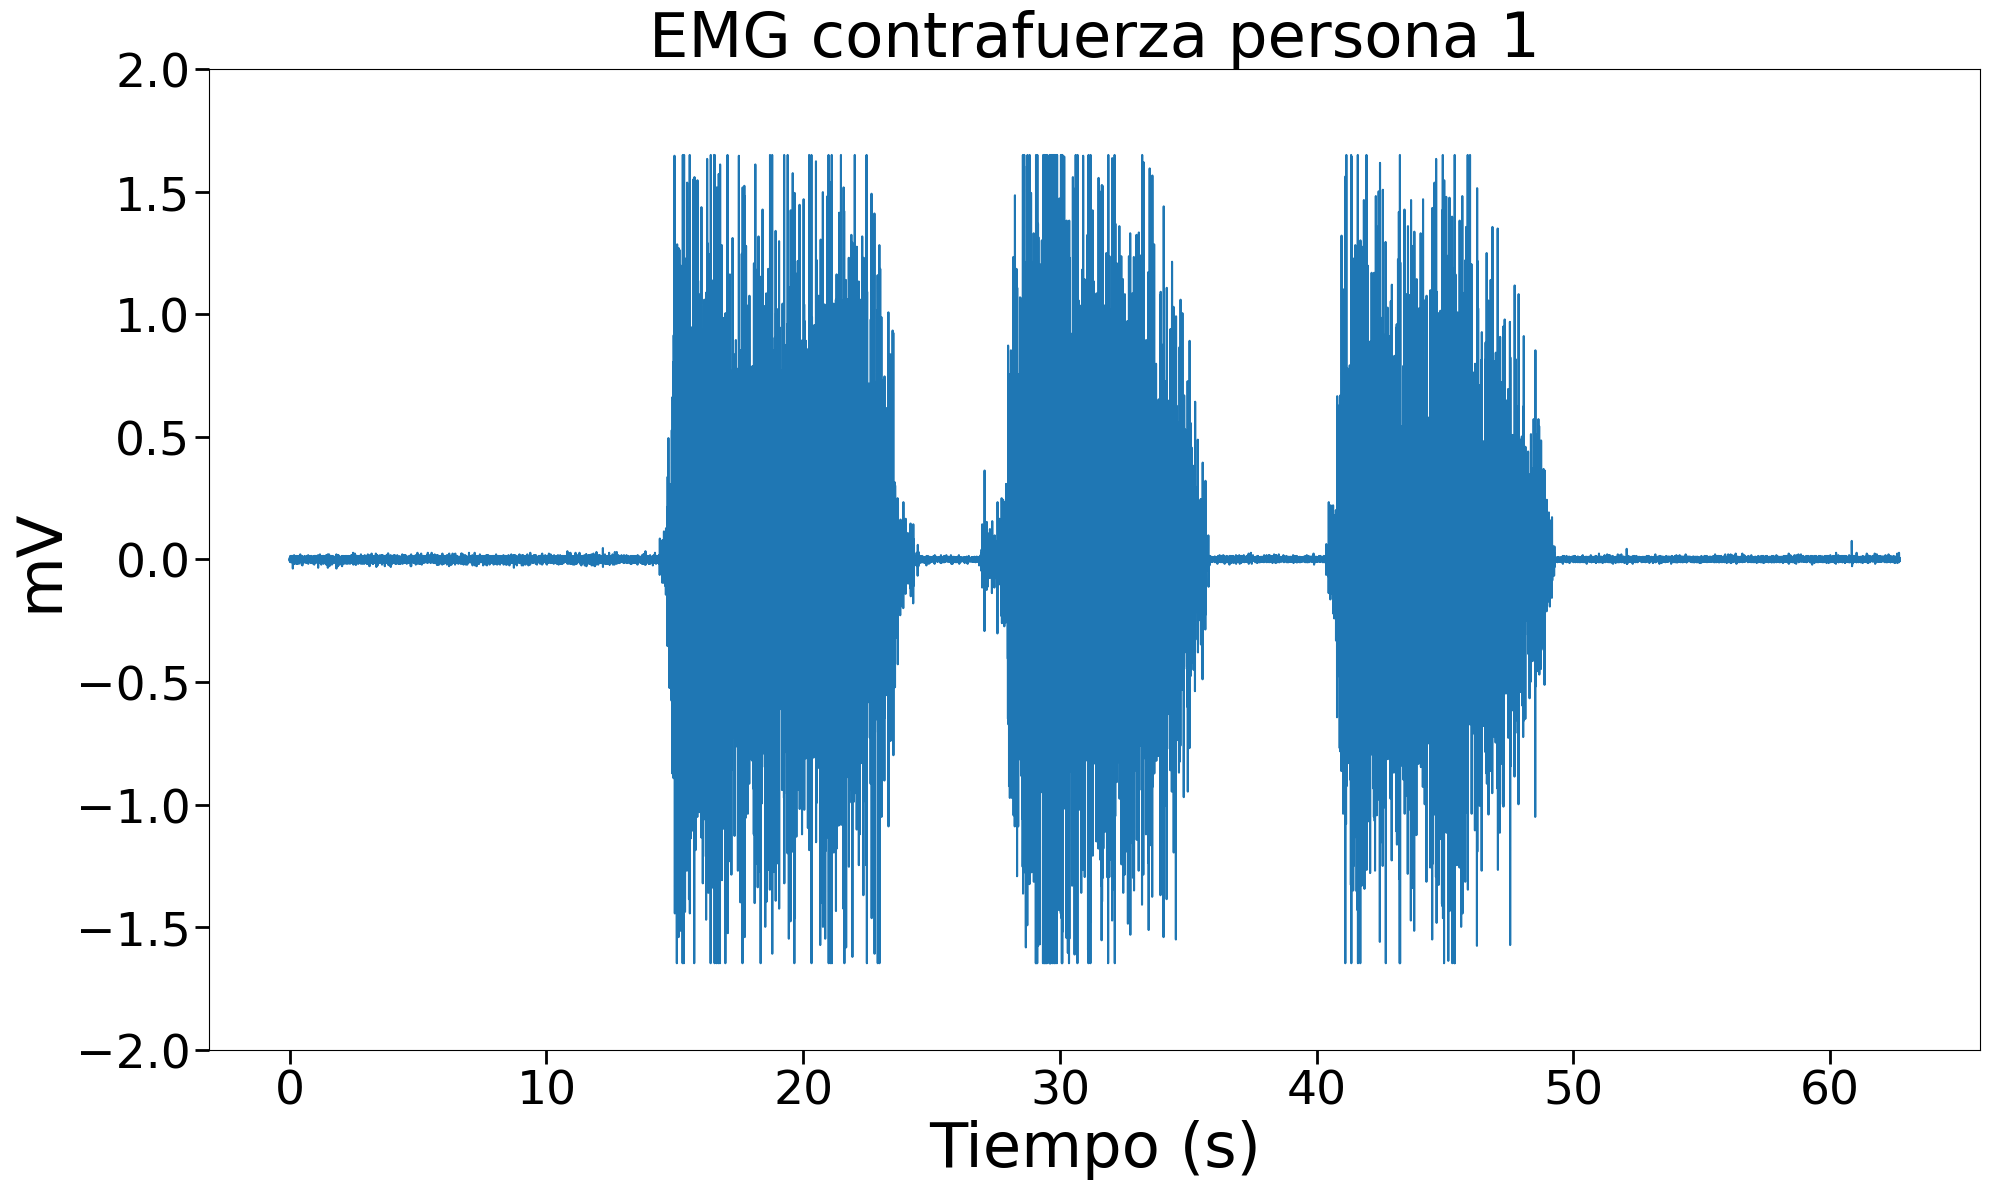

In [26]:
data=np.loadtxt("./../Laboratorio 04/emg_raw_data/isb-contrafuerza-armando/opensignals_98D3B1FD3DA9_2024-04-12_12-19-52.txt",skiprows=3)

bits = 10 # Bits de la salida 
volt_range = 3.3 #Rango de voltaje en milivoltios
data_mV = (data[:,5] * volt_range/(2**bits - 1)) # convertir los bits a mV
data_mV_centered = data_mV - np.mean(data_mV)  # Centrar la señal

# Rectify the signal (full-wave rectification)
data_mV_rectified = np.abs(data_mV_centered)

time = np.arange(len(data_mV))/1000 

plt.figure(figsize=(20,12))

plt.plot(time,data_mV_centered)

plt.ylim(-2, 2)
#plt.xlim(13, 31)
plt.tick_params(axis='both', which='major', labelsize=34, width=2, length=10)
plt.xlabel('Tiempo (s)', fontsize=45)
plt.ylabel('mV', fontsize=45)
plt.title('EMG contrafuerza persona 1', fontsize=45)
plt.tight_layout()

plt.savefig("plots/isb-contrafuerza-armando.png")

#Tomamos solo 5 segundos de la señal
y_1=data_mV[15000:20000]

Fs = 1000
Ts=1/Fs # Determinar el periodo de muestreo
t_1 = np.arange(0, len(y_1)*Ts, Ts) # Crear vector de tiempo considerando periodo de muestreo



/Users/diegotaquiri/miniconda3/envs/isb/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1961: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '


       Average  Standard Deviation   Maximum   Minimum       RMS      Area  \
0     0.004808            0.004511  0.039109  0.000187  0.006593  0.954632   
1     0.004845            0.004509  0.039109  0.000075  0.006618  0.963233   
2     0.005300            0.004755  0.039109  0.000075  0.007120  1.057495   
3     0.005163            0.004817  0.039109  0.000075  0.007061  1.023841   
4     0.004830            0.003862  0.017884  0.000075  0.006184  0.960574   
...        ...                 ...       ...       ...       ...       ...   
1558  0.003635            0.002890  0.013740  0.000058  0.004644  0.722077   
1559  0.003838            0.003128  0.013740  0.000058  0.004952  0.760897   
1560  0.003980            0.003181  0.013740  0.000033  0.005095  0.793686   
1561  0.004277            0.003597  0.021915  0.000033  0.005589  0.850758   
1562  0.004349            0.003555  0.021915  0.000033  0.005617  0.862548   

      Total Power  Median Frequency  Max Frequency   Kurtosis  

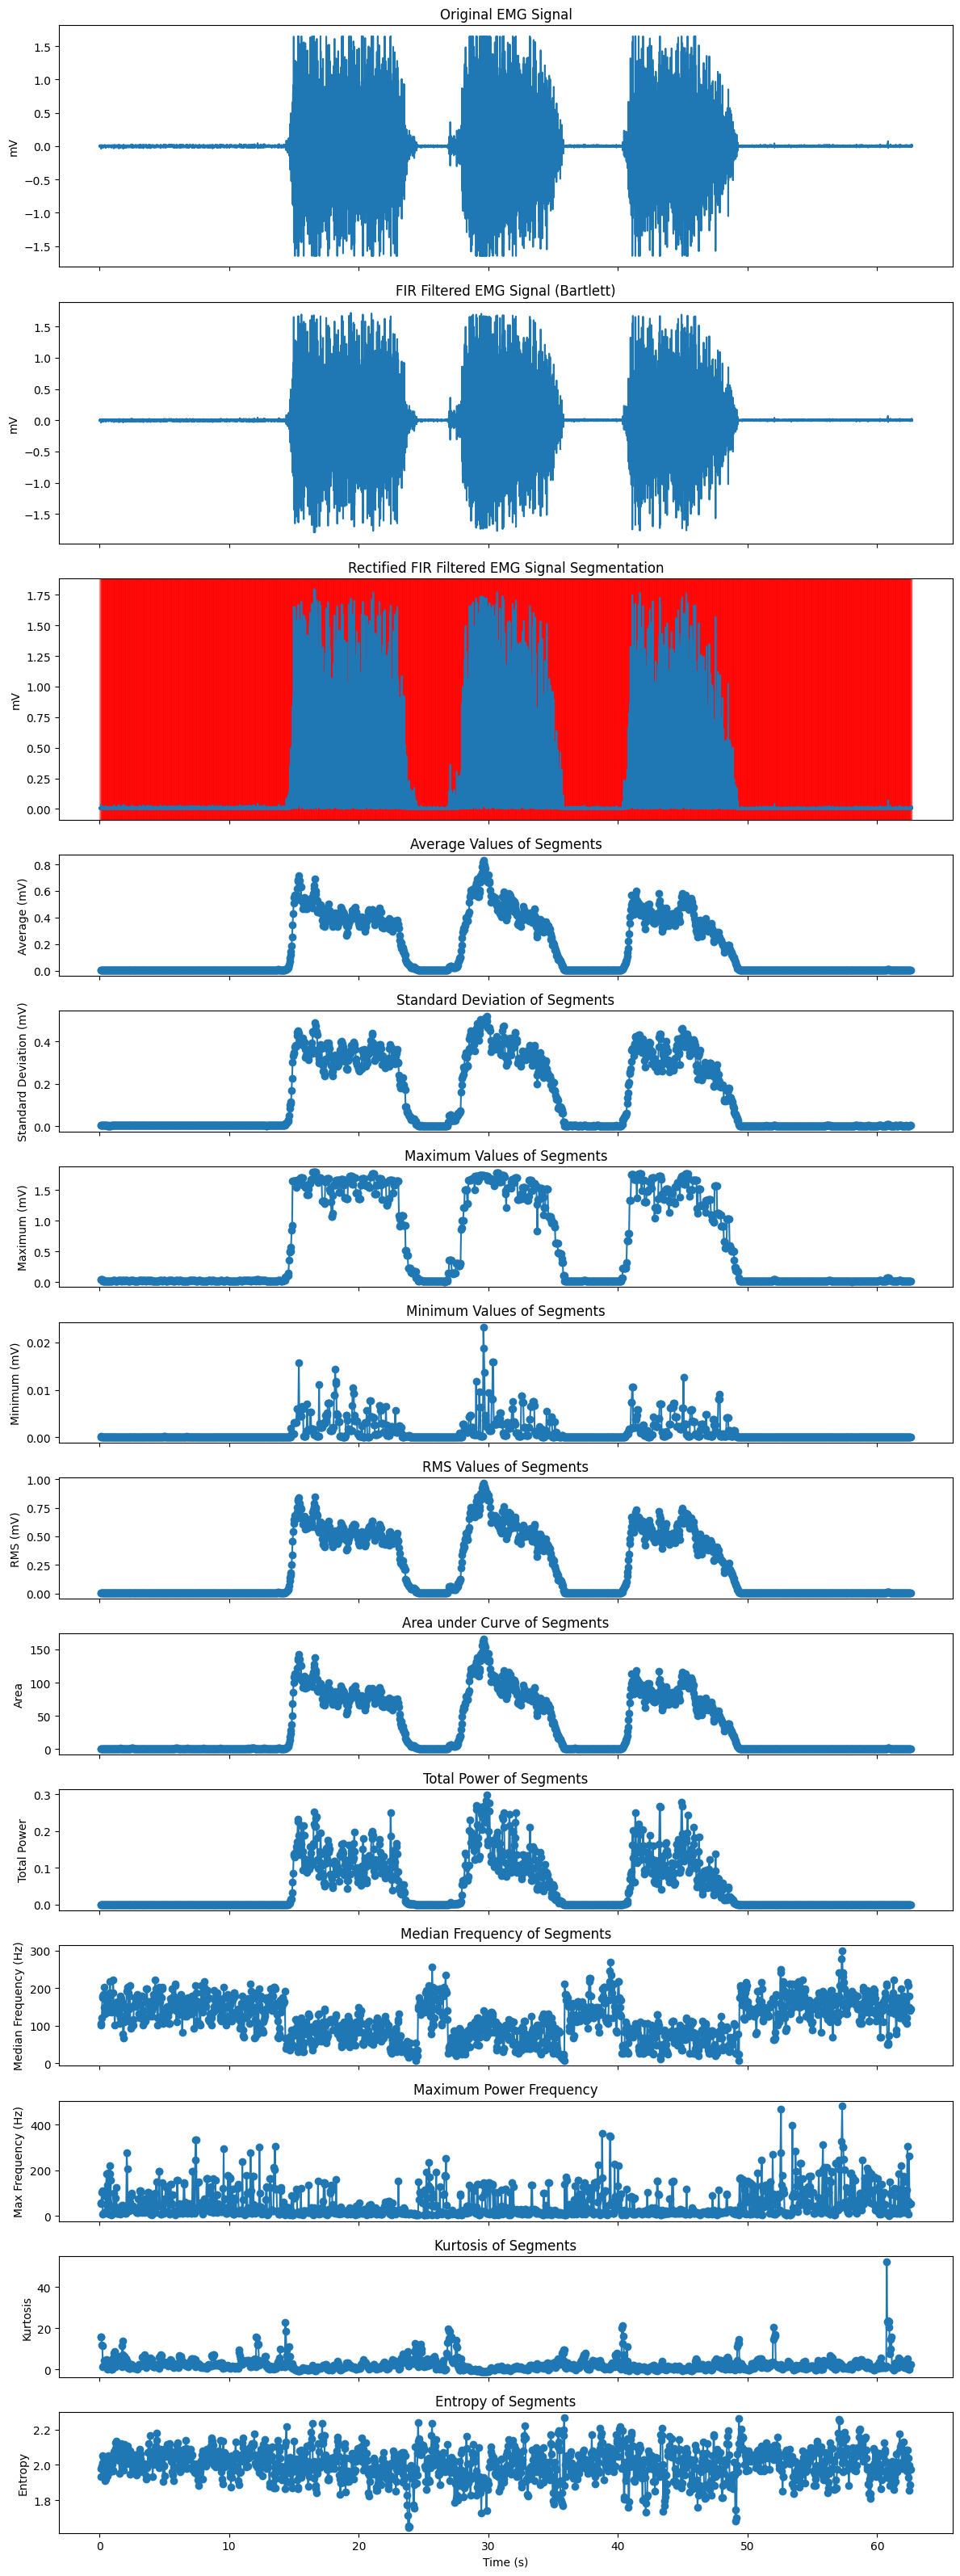

In [28]:
# FIR filter design
def bartlett_fir(data, cutoff, fs, order=20):
    coeff = firwin(order + 1, cutoff / (fs / 2), window='bartlett')
    filtered_data = filtfilt(coeff, 1.0, data)
    return filtered_data

# Apply FIR filter
filtered_fir_bartlett = bartlett_fir(data_mV_centered, cutoff=400, fs=1000, order=20)
filtered_fir_bartlett_rectified = np.abs(filtered_fir_bartlett)

# Segment the EMG signal
def segment_signal(signal, segment_length, increment, sampling_rate):
    segment_samples = int(segment_length * sampling_rate / 1000)
    increment_samples = int(increment * sampling_rate / 1000)
    segments = []
    for start in range(0, len(signal) - segment_samples + 1, increment_samples):
        end = start + segment_samples
        segments.append(signal[start:end])
    return np.array(segments), segment_samples, increment_samples, np.arange(0, len(signal) - segment_samples + 1, increment_samples)

# Segment parameters
segment_length = 200
increment = 40
sampling_rate = 1000

# Segment the rectified filtered signal
segments, segment_samples, increment_samples, segment_starts = segment_signal(filtered_fir_bartlett_rectified, segment_length, increment, sampling_rate)

# Additional feature extraction functions
def calculate_kurtosis(signal):
    return kurtosis(signal)

def calculate_entropy(signal):
    return entropy(np.histogram(signal, bins='fd')[0])

def calculate_snr(original_segment, filtered_segment):
    noise = original_segment - filtered_segment
    signal_power = np.mean(original_segment ** 2)
    noise_power = np.mean(noise ** 2)
    return 10 * np.log10(signal_power / noise_power) if noise_power != 0 else float('inf')

# Feature extraction function
def extract_features(segment, sampling_rate, original_signal, segment_start, segment_length):
    max_sample_value = np.max(segment)
    min_sample_value = np.min(segment)
    avg_sample_value = np.mean(segment)
    std_sample_value = np.std(segment)
    rms = np.sqrt(np.mean(segment ** 2))
    area = np.trapz(segment)
    f, P = welch(segment, fs=sampling_rate, window='hanning', noverlap=0, nfft=int(256.))
    area_freq = cumtrapz(P, f, initial=0)
    total_power = area_freq[-1]
    median_freq = f[np.where(area_freq >= total_power / 2)[0][0]]
    f_max = f[np.argmax(P)]
    kurt = calculate_kurtosis(segment)
    ent = calculate_entropy(segment)
    original_segment = original_signal[segment_start:segment_start + segment_length]
    snr = calculate_snr(original_segment, segment)
    return [avg_sample_value, std_sample_value, max_sample_value, min_sample_value, rms, area, total_power, median_freq, f_max, kurt, ent, snr]

# Extract features from each segment
features = []
for i, segment in enumerate(segments):
    segment_start = segment_starts[i]
    features.append(extract_features(segment, sampling_rate, data_mV_centered, segment_start, segment_samples))

features_df = pd.DataFrame(features, columns=['Average', 'Standard Deviation', 'Maximum', 'Minimum', 'RMS', 'Area', 'Total Power', 'Median Frequency', 'Max Frequency', 'Kurtosis', 'Entropy', 'SNR'])
print(features_df)

# Plot the original, filtered, and segmented signals with features
fig, axs = plt.subplots(14, 1, figsize=(12, 32), sharex=True, gridspec_kw={'height_ratios': [2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]})

# Plot original EMG signal
axs[0].plot(time, data_mV_centered)
axs[0].set_ylabel('mV')
axs[0].set_title('Original EMG Signal')

# Plot FIR filtered EMG signal
axs[1].plot(time, filtered_fir_bartlett)
axs[1].set_ylabel('mV')
axs[1].set_title('FIR Filtered EMG Signal (Bartlett)')

# Plot rectified FIR filtered EMG signal with segmentation
axs[2].plot(time, filtered_fir_bartlett_rectified)
axs[2].set_ylabel('mV')
axs[2].set_title('Rectified FIR Filtered EMG Signal Segmentation')
for start in segment_starts:
    end = start + segment_samples
    if end < len(time):
        axs[2].axvspan(time[start], time[end], color='red', alpha=0.3)

# Plot feature values
mean_times = (segment_starts + segment_samples / 2) / sampling_rate

# Plot Average values
axs[3].plot(mean_times, features_df['Average'], marker='o')
axs[3].set_ylabel('Average (mV)')
axs[3].set_title('Average Values of Segments')

# Plot Standard Deviation values
axs[4].plot(mean_times, features_df['Standard Deviation'], marker='o')
axs[4].set_ylabel('Standard Deviation (mV)')
axs[4].set_title('Standard Deviation of Segments')

# Plot Maximum values
axs[5].plot(mean_times, features_df['Maximum'], marker='o')
axs[5].set_ylabel('Maximum (mV)')
axs[5].set_title('Maximum Values of Segments')

# Plot Minimum values
axs[6].plot(mean_times, features_df['Minimum'], marker='o')
axs[6].set_ylabel('Minimum (mV)')
axs[6].set_title('Minimum Values of Segments')

# Plot RMS values
axs[7].plot(mean_times, features_df['RMS'], marker='o')
axs[7].set_ylabel('RMS (mV)')
axs[7].set_title('RMS Values of Segments')

# Plot Area values
axs[8].plot(mean_times, features_df['Area'], marker='o')
axs[8].set_ylabel('Area')
axs[8].set_title('Area under Curve of Segments')

# Plot Total Power values
axs[9].plot(mean_times, features_df['Total Power'], marker='o')
axs[9].set_ylabel('Total Power')
axs[9].set_title('Total Power of Segments')

# Plot Median Frequency values
axs[10].plot(mean_times, features_df['Median Frequency'], marker='o')
axs[10].set_ylabel('Median Frequency (Hz)')
axs[10].set_title('Median Frequency of Segments')

# Plot Max Frequency values
axs[11].plot(mean_times, features_df['Max Frequency'], marker='o')
axs[11].set_ylabel('Max Frequency (Hz)')
axs[11].set_title('Maximum Power Frequency')

# Plot Kurtosis values
axs[12].plot(mean_times, features_df['Kurtosis'], marker='o')
axs[12].set_ylabel('Kurtosis')
axs[12].set_title('Kurtosis of Segments')

# Plot Entropy values
axs[13].plot(mean_times, features_df['Entropy'], marker='o')
axs[13].set_ylabel('Entropy')
axs[13].set_title('Entropy of Segments')

axs[13].set_xlabel('Time (s)')

plt.tight_layout()
plt.savefig("plots/isb-contrafuerza-armando-feature-extracion.png")

plt.show()